First we define the class **Lever** which will have a static distribution with a mean selected randomly and will be able to yield values from that distribution

In [4]:
import numpy as np

class Lever:
    def __init__(self, stdev, minimum, maximum):
        """
        Initializes a lever with specific parameters
        :param stdev:   Standard deviation for the distribution
        :param minimum: Minimum accepted value as reward (to prevent outliers)
        :param maximum: Maximum accepted value as reward (to prevent outliers)
        """

        # The mean is randomly selected
        self.mean = np.random.uniform(minimum, maximum)
        self.stdev = stdev
        self.min = minimum
        self.max = maximum

    def random(self, sample_size=None):
        """
        Returns one or more random values from the distribution
        :param sample_size: number of samples to return, default None = 1 sample
        """
        return np.random.normal(self.mean, self.stdev, sample_size)

    def get_sample(self):
        """
        Activates the lever and returns a valid reward
        """
        reward = self.random()
        while reward < self.min or reward > self.max:
            reward = self.random()

        return reward

    def __str__(self):
        """
        Prints the object metadata
        """
        return "mean: {}, stdev:{}".format(self.mean, self.stdev)

And then a class for the **Environment** that will create **k** levers and redirect the actions that the agent my perform

In [144]:
class KArmedBanditEnvironment:
    def __init__(self, k, stdev=1, minimum=-3, maximum=3):
        """
        Initializes an environment
        :param k: number of levers in the environment
        :param stdev: default standard deviation for all lever distributions
        :param minimum: minimum allowed reward
        :param maximum: maximum allowed reward
        """
        self.n_arms = k
        self.arms = [Lever(stdev, minimum, maximum) for _ in range(0, self.n_arms)]
        self.plays = 0

    def __best_action(self):
        """
        Private method that returns the lever with highest mean
        """
        return np.argmax([arm.mean for arm in self.arms])

    def get_samples(self, sample_size=10000):
        return [arm.random(sample_size) for arm in self.arms]

    def perform_action(self, k):
        """
        Actually activates a lever
        :param k: selected lever to be activated
        :return: reward given by lever k
        """
        assert (k < self.n_arms)
        reward = self.arms[k].get_sample()
        self.plays += 1
        return reward

    def __str__(self):
        """
        Prints the object metadata
        """
        return str([str(arm) for arm in self.arms])

Now we need an **Agent** that will interact with the environment and decide the actions to be taken

In [145]:
class KArmedBanditAgent:
    def __init__(self, k, epsilon=0.1):
        """
        Initializes an agent
        :param k: Number of levers available for the agent
        :param epsilon: Parameter to control exploration and exploitation
        """

        self.n_arms = k
        self.epsilon = epsilon
        self.reward_sum = np.zeros(self.n_arms)
        self.n_plays = np.zeros(self.n_arms)
        self.values = np.zeros(self.n_arms)
        self.cumulative_reward = 0

    def get_action(self):
        """
        Uses the computed rewards averages as a value function
        and the epsilon value to decide for the next action
        :return: The agent's next action
        """
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.randint(0, self.n_arms)
        else:
            action = np.argmax(self.values)

        return action

    def set_reward(self, action, reward):
        """
        Updates the value function
        :param action: The agent's previously selected action
        :param reward: The reward received for selection that action
        """
        self.reward_sum[action] += reward
        self.n_plays[action] += 1
        self.values[action] = self.reward_sum[action] / self.n_plays[action]
        self.cumulative_reward += reward


Now we need to be able to run the simulation, the **Runner** will build the bridge between the environment and the agent and simulate the interactions

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

class Runner:
    def __init__(self, env, agent, iterations=10000):
        """
        Initializes an instance to run the simulation and collect some statistics
        :param env: KArmedBandit Environment
        :param agent: KArmedBandit Agent
        :param iterations: Number of times the agent will select actions
        """
        self.env = env
        self.agent = agent
        self.iterations = iterations
        self.palette = sns.color_palette("muted", n_colors=self.env.n_arms)

    def run(self):
        """
        Runs the simulation
        """
        # Resets agent status
        agent.__init__(k=env.n_arms)
        for i in range(1, self.iterations):
            # Gets the action from the agent
            action = self.agent.get_action()

            # Executes action on environment
            reward = self.env.perform_action(action)

            # Gives reward as feedback for agent
            self.agent.set_reward(action, reward)

    def plot_environment(self):
        """
        plots the different distributions
        """
        sns.set()
        fig = plt.figure(figsize=(20, 8))
        ax = fig.add_subplot(1, 1, 1)

        samples = (self.env.get_samples(self.iterations))
        sns.violinplot(data=samples, ax=ax, palette=self.palette)
        plt.show()

    def plot_selected_actions(self):
        """
        plots the number of times each action was selected
        """
        sns.set()
        fig = plt.figure(figsize=(20, 8))
        ax1 = fig.add_subplot(1, 1, 1)
        sns.barplot(x=list(range(0, self.env.n_arms)), y=self.agent.n_plays, ax=ax1, palette=self.palette)
        plt.show()

    def plot_value_function(self):
        """
        plots the number of times each action was selected
        """
        sns.set()
        fig = plt.figure(figsize=(20, 8))
        ax1 = fig.add_subplot(1, 1, 1)
        samples = self.env.get_samples(self.iterations)
        sns.violinplot(data=samples, ax=ax1, palette=self.palette)
        shift = 0.1
        sns.scatterplot(x=list(np.arange(0 - shift, self.env.n_arms - shift)),
                        y=self.agent.values,
                        ax=ax1,
                        marker='>',
                        s=200, color="black")
        plt.show()


Let's define our objects

In [172]:
env = KArmedBanditEnvironment(k=8)
agent = KArmedBanditAgent(k=env.n_arms)
runner = Runner(env, agent, 100000)

Before we actually run the simulation let's take a look at the environment an the reward distributions for each lever

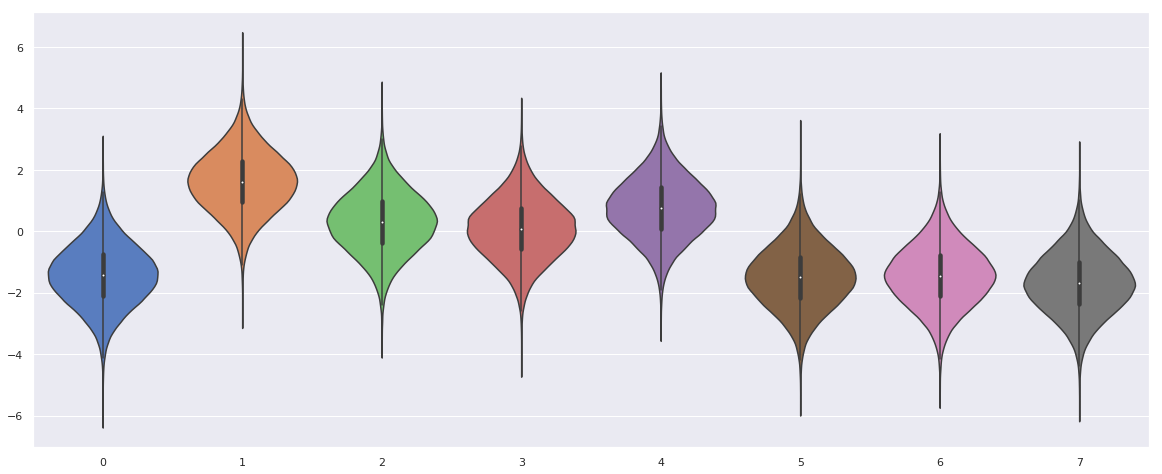

In [173]:
runner.plot_environment()

Ok, we can get the shape of the problem, lever number 2 seems to have the highest mean, but our agent doesn't know that yet, let's run the simulation

In [180]:
%%time
runner.run()

CPU times: user 680 ms, sys: 30 µs, total: 680 ms
Wall time: 677 ms


In the following plot we compare the estimated value function for the actions with their known empirical distribution

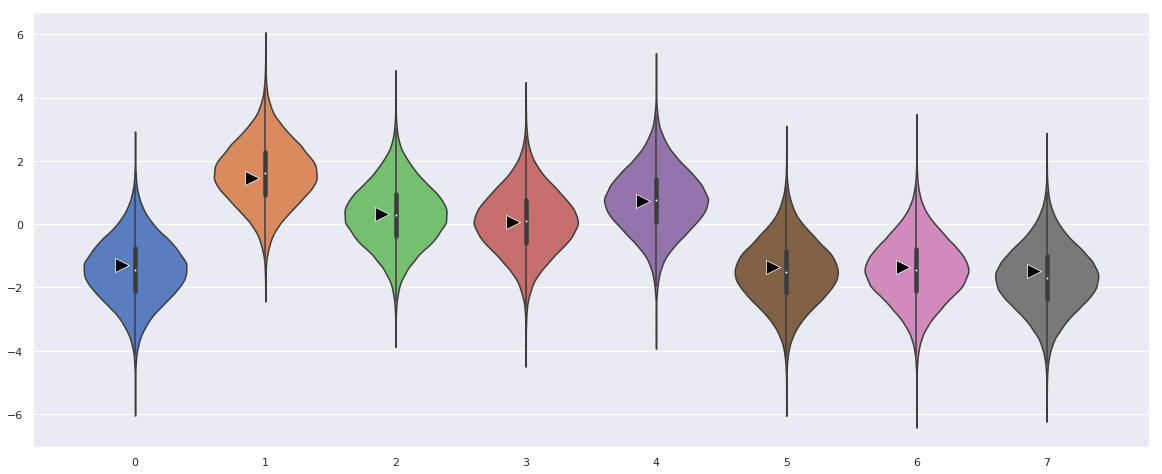

In [181]:
runner.plot_value_function()

Ok, so the agent managed to gather estimates pretty close to the actual values, let's take a look on how it performed and how many times it selected each actions

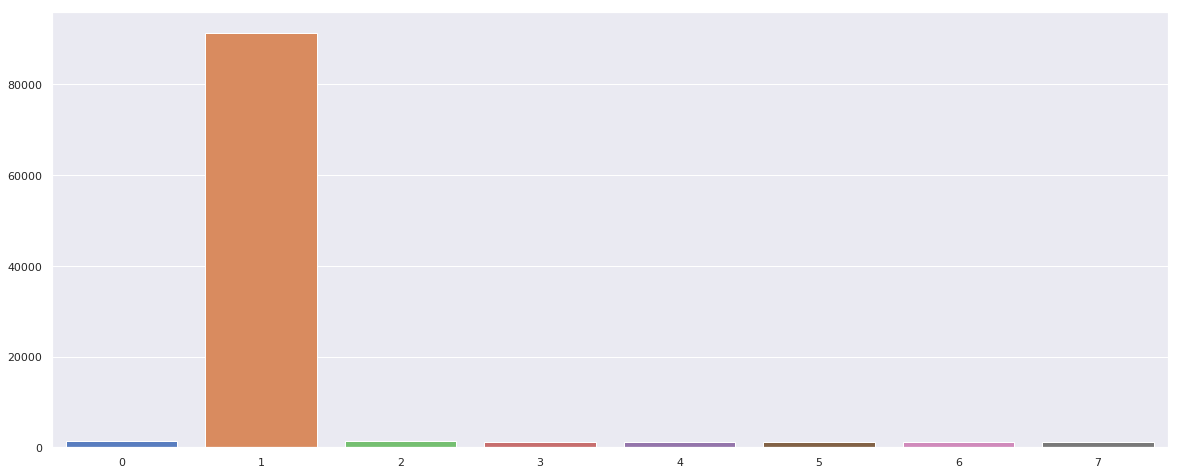

In [182]:
runner.plot_selected_actions()